# Data loading

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from xgboost import XGBClassifier
from catboost import CatBoostClassifier


import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
pd.set_option('mode.chained_assignment', None)

In [46]:
df_sessions = pd.read_csv("../model/data/ga_sessions.csv")

C:\Users\gameo\AppData\Local\Temp\ipykernel_12648\1580962794.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sessions = pd.read_csv("../model/data/ga_sessions.csv")


In [47]:
import psutil

# Получаем информацию о памяти
memory_info = psutil.virtual_memory()

# Выводим информацию о памяти
print(f"Всего памяти: {memory_info.total / (1024 ** 3):.2f} ГБ")
print(f"Использовано памяти: {memory_info.used / (1024 ** 3):.2f} ГБ")
print(f"Свободно памяти: {memory_info.available / (1024 ** 3):.2f} ГБ")
print(f"Процент использования памяти: {memory_info.percent}%")

Всего памяти: 31.60 ГБ
Использовано памяти: 10.99 ГБ
Свободно памяти: 20.61 ГБ
Процент использования памяти: 34.8%


# Data Preparation

## Data explore

In [48]:
df_sessions.shape

(1860042, 18)

In [49]:
df_sessions.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1.860042e+06,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1492864,16338,1860042,1860042,1860042,1860042
unique,1860042,1.391717e+06,226,85318,NaN,293,56,412,286,1219,3,13,205,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1.750498e+09,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,4.620000e+02,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
def print_full_row_info(df):
    print("Кол-во полностью заполненных", len(df.dropna()))
    print("Процент полностью заполненных", round((len(df.dropna()) / len(df)) * 100, 2))

print_full_row_info(df_sessions)

Кол-во полностью заполненных 14940
Процент полностью заполненных 0.8


In [51]:
((df_sessions.isna().sum() / len(df_sessions)) * 100).sort_values(ascending=False)


device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
session_id                   0.000000
client_id                    0.000000
visit_number                 0.000000
utm_medium                   0.000000
visit_date                   0.000000
visit_time                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64

## Data cleaning

### Sessions

In [52]:
df_sessions['client_id'] = df_sessions['client_id'].astype(str)

#### device_os

In [53]:
df_sessions.device_os.value_counts(dropna=False)

device_os
NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: count, dtype: int64

In [54]:
device_os_values = list(df_sessions.device_os.unique())
device_os_values.remove('(not set)')
device_os_values.remove(np.nan)

device_os_values

['Android',
 'iOS',
 'Windows',
 'Linux',
 'Macintosh',
 'Chrome OS',
 'BlackBerry',
 'Tizen',
 'Firefox OS',
 'Samsung',
 'Windows Phone',
 'Nokia']

In [55]:
for os in device_os_values:
    all_device_Android = df_sessions[df_sessions.device_os == os].device_brand.unique().tolist()
    if "(not set)" in all_device_Android:
        all_device_Android.remove("(not set)")
    for phone in all_device_Android:
        df_sessions.loc[
            (df_sessions['device_os'].isna()) & 
            (df_sessions['device_brand'] == phone),
            'device_os'
        ] = os

In [56]:
df_sessions.device_os.value_counts(dropna=False)

device_os
Android          933857
iOS              551094
NaN              256345
Windows           88307
Macintosh         24824
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

In [57]:
android = ['Instagram 208.0.0.32.135 Android', 'Android Webview',
       'Instagram 209.0.0.21.119 Android', 'Android', 'Instagram 199.1.0.34.119 Android',
       'Instagram 194.0.0.36.172 Android', 'Opera Mini', 'Puffin',
       'Instagram 202.0.0.37.123 Android', 'Samsung Internet', 'com.vk.vkclient',
       'Instagram 192.0.0.35.123 Android', 'Android Browser', 'UC Browser'
       'Instagram 158.0.0.30.123 Android', 'Android Runtime', 'Threads 202.0.0.23.119']
df_sessions.loc[
    (df_sessions['device_os'].isna()) & 
    (df_sessions['device_browser'].isin(android)),
    'device_os'
] = 'Android'

df_sessions.device_os.value_counts(dropna=False)

device_os
Android          935168
iOS              551094
NaN              255034
Windows           88307
Macintosh         24824
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

In [58]:
df_sessions[df_sessions.device_os.isna()].device_browser.unique()

array(['YaBrowser', 'Chrome', 'Safari', 'Firefox', 'Opera', 'Edge',
       '(not set)', 'Mozilla Compatible Agent', 'Coc Coc', '[FBAN',
       'Internet Explorer', 'MRCHROME', 'UC Browser', 'SeaMonkey',
       'Mozilla', 'Maxthon', 'Instagram 158.0.0.30.123 Android',
       'Konqueror'], dtype=object)

In [59]:
df_sessions[df_sessions.device_browser == 'Safari'].device_os.unique()

array(['iOS', nan, 'Macintosh', 'Android', 'Linux', 'Windows Phone',
       'Nokia'], dtype=object)

In [60]:
browsers_os = {
    'YaBrowser': 'Windows',  # Чаще используется на Windows, но есть версии для macOS и Android.
    'Chrome': 'Windows',  # Самый распространённый браузер, но предполагаем Windows.
    'Safari': 'iOS',  # Safari — браузер Apple, работает только на macOS и iOS.
    'Firefox': 'Windows',  # Firefox кроссплатформенный, но чаще встречается на Windows.
    'Opera': 'Windows',  # Opera работает везде, но в основном на Windows.
    'Edge': 'Windows',  # Браузер от Microsoft, стандартный для Windows.
    '(not set)': '(not set)',  # Нет информации о браузере, операционную систему определить нельзя.
    'Mozilla Compatible Agent': 'Windows',  # Это может быть что угодно, требует уточнения.
    'Coc Coc': 'Windows',  # Вьетнамский браузер на основе Chromium, доступен для Windows и macOS.
    '[FBAN': 'iOS',  # User-Agent Facebook App, чаще всего встречается на iOS.
    'Internet Explorer': 'Windows',  # Классический браузер Windows.
    'MRCHROME': 'Windows',  # Вероятно, специфическая версия Chrome.
    'UC Browser': 'Android',  # Браузер популярен среди пользователей Android.
    'SeaMonkey': 'Windows',  # Браузер на основе Mozilla, чаще используется на Windows.
    'Mozilla': 'Windows',  # Может быть разным, но чаще всего это Windows.
    'Maxthon': 'Windows',  # Браузер, работающий на разных платформах, но чаще на Windows.
    'Konqueror': 'Linux'  # Браузер KDE, используется в основном на Linux.
}

df_sessions.loc[
    (df_sessions['device_os'].isna()) & 
    (df_sessions['device_browser'].isin(browsers_os.keys())),
    'device_os'
] = df_sessions['device_browser'].map(browsers_os)

In [61]:
df_sessions.device_os.value_counts(dropna=False)

device_os
Android          935181
iOS              578787
Windows          315620
Macintosh         24824
Linux              5121
(not set)           375
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
NaN                   3
Name: count, dtype: int64

#### device_brand

In [62]:
df_sessions.device_brand.value_counts(dropna=False).head(20) # слишком много пропусков, попробуем добавить новую категорию unknown

device_brand
Apple        551088
NaN          367178
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Meizu          3750
Lenovo         3148
Blackview      2759
Tecno          2654
LG             2447
Name: count, dtype: int64

In [63]:
df_sessions.loc[
    (df_sessions['device_brand'].isna()) & 
    (df_sessions['device_os'] == 'Macintosh'),
    'device_brand'
    ] = 'Apple'
df_sessions.device_brand.value_counts(dropna=False).head(20) # слишком много пропусков, попробуем добавить новую категорию unknown

device_brand
Apple        575912
NaN          342354
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Meizu          3750
Lenovo         3148
Blackview      2759
Tecno          2654
LG             2447
Name: count, dtype: int64

In [64]:
df_sessions.loc[
    (df_sessions['device_brand'].isna()) & 
    (df_sessions['device_os'] == 'Windows') &
    (df_sessions['device_category'] == 'desktop'),
    'device_brand'
    ] = '(not set)'
df_sessions.device_brand.value_counts(dropna=False)

device_brand
Apple        575912
Samsung      332194
(not set)    325904
Xiaomi       288367
Huawei       185853
              ...  
Maze              1
Tagital           1
FREETEL           1
Maxvi             1
Opera             1
Name: count, Length: 206, dtype: int64

In [65]:
df_sessions['device_brand'].fillna('(not set)', inplace=True)

C:\Users\gameo\AppData\Local\Temp\ipykernel_12648\1673585503.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sessions['device_brand'].fillna('(not set)', inplace=True)


In [66]:
((df_sessions.isna().sum() / len(df_sessions)) * 100).sort_values(ascending=False)


device_model                99.121633
utm_keyword                 58.174009
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
device_os                    0.000161
client_id                    0.000000
session_id                   0.000000
visit_number                 0.000000
visit_time                   0.000000
utm_medium                   0.000000
visit_date                   0.000000
device_category              0.000000
device_brand                 0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64

## Data Visualization

In [67]:
df_sessions.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1860042,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,1860039,1860042,16338,1860042,1860042,1860042,1860042
unique,1860042,1391717,226,85318,NaN,293,56,412,286,1219,3,13,205,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1750498477.162945,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,462,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,935181,575912,9778,169090,1013436,1800565,805329
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


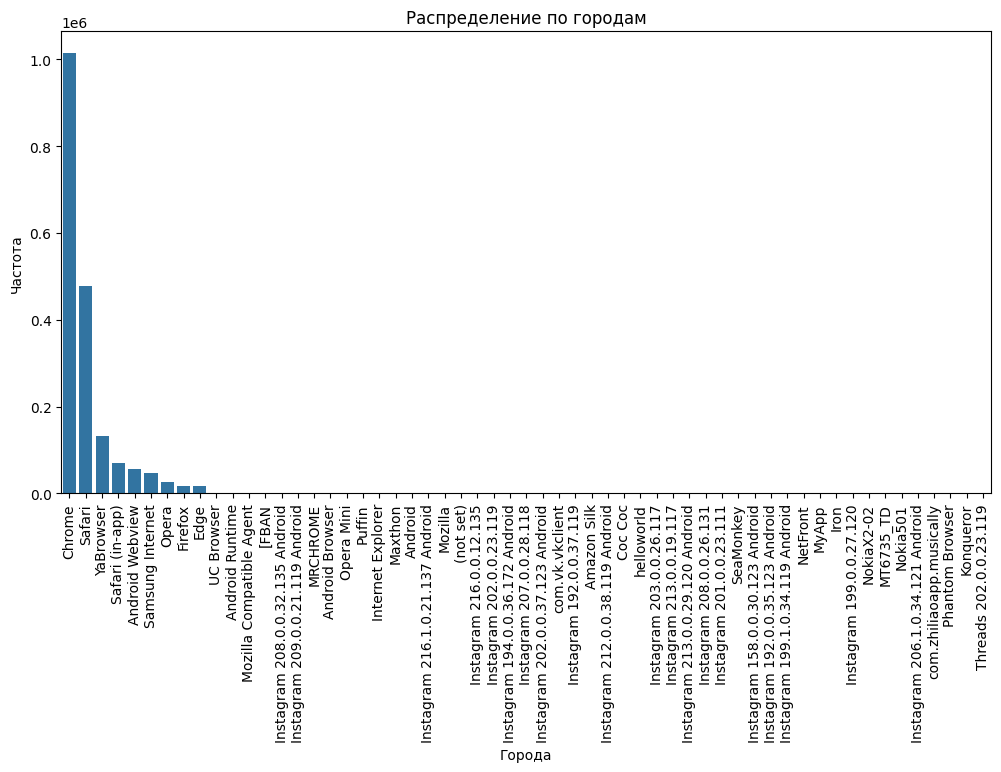

In [68]:
y = df_sessions['device_browser'].value_counts()  # Получаем распределение категорий

plt.figure(figsize=(12, 6))
sns.barplot(x=y.index, y=y.values)
plt.xticks(rotation=90)  
plt.xlabel("Города")
plt.ylabel("Частота")
plt.title("Распределение по городам")
plt.show()


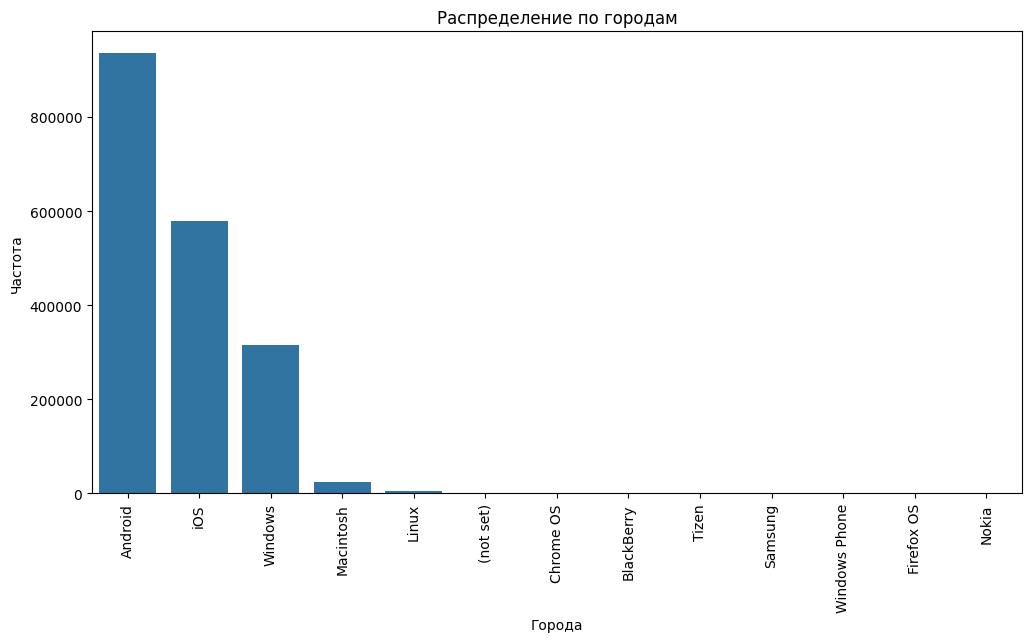

In [69]:
y = df_sessions['device_os'].value_counts()  # Получаем распределение категорий

plt.figure(figsize=(12, 6))
sns.barplot(x=y.index, y=y.values)
plt.xticks(rotation=90)  
plt.xlabel("Города")
plt.ylabel("Частота")
plt.title("Распределение по городам")
plt.show()


# Feature Enginering

## Creating new features

In [70]:
organic_traffic = ['organic', 'referral', '(none)']

# Создание новой колонки organic_traffic
df_sessions['organic_traffic'] = df_sessions['utm_medium'].apply(lambda x: 1 if x in organic_traffic else 0)

In [71]:
social_media = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
                      'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']

df_sessions['social_media_ad'] = df_sessions['utm_source'].apply(lambda x: 1 if x in social_media else 0)

In [72]:
df_sessions['visit_date'] = pd.to_datetime(df_sessions['visit_date'])
df_sessions['year'] = df_sessions['visit_date'].dt.year
df_sessions['month'] = df_sessions['visit_date'].dt.month
df_sessions['day'] = df_sessions['visit_date'].dt.day
df_sessions.head(1)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,device_model,device_screen_resolution,device_browser,geo_country,geo_city,organic_traffic,social_media_ad,year,month,day
0,9055434745589932991.1637753792.1637753792,2108382700.1637757,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,NaN,360x720,Chrome,Russia,Zlatoust,0,0,2021,11,24


In [73]:
df_sessions['visit_time'] = pd.to_timedelta(df_sessions['visit_time'])

# Извлекаем компоненты времени
df_sessions['hour'] = (df_sessions['visit_time'].dt.total_seconds() // 3600).astype(int)
df_sessions['minute'] = ((df_sessions['visit_time'].dt.total_seconds() % 3600) // 60).astype(int)
df_sessions['second'] = (df_sessions['visit_time'].dt.total_seconds() % 60).astype(int)

df_sessions.head(1)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,geo_country,geo_city,organic_traffic,social_media_ad,year,month,day,hour,minute,second
0,9055434745589932991.1637753792.1637753792,2108382700.1637757,2021-11-24,0 days 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Russia,Zlatoust,0,0,2021,11,24,14,36,32


In [74]:
groups = {
    'ad_channel': ['banner', 'cpm', 'cpc', 'cpv', 'cpa', 'smartbanner', 'promo_sbol', 
                   'promo_sber', 'reach', 'desktop', 'tablet', 'static', 'CPM'],
    
    'organic_channel': ['organic', '(none)', '(not set)'],
    
    'referral_channel': ['referral', 'link', 'linktest', 'qr', 'qrcodevideo'],
    
    'social': ['smm', 'stories', 'blogger_channel', 'blogger_stories', 
               'blogger_header', 'vk_smm', 'fb_smm', 'ok_smm', 'tg', 'social'],
    
    'email_sms': ['email', 'sms', 'outlook'],
    
    'app_catalogue': ['app', 'sber_app', 'Sbol_catalog', 'catalogue', 
                      'landing_interests', 'web_polka', 'main_polka'],
    
    'other_channel': ['push', 'partner', 'post', 'article', 'users_msk', 
                      'cbaafe', 'dom_click', 'medium', 'last', 'clicks', 
                      'landing', 'info_text', 'nkp', 'google_cpc', 'yandex_cpc']
}

def get_group(value):
    for group, values in groups.items():
        if value in values:
            return group
    return None

df_sessions['utm_medium_group'] = df_sessions['utm_medium'].apply(get_group)

In [75]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 27 columns):
 #   Column                    Dtype          
---  ------                    -----          
 0   session_id                object         
 1   client_id                 object         
 2   visit_date                datetime64[ns] 
 3   visit_time                timedelta64[ns]
 4   visit_number              int64          
 5   utm_source                object         
 6   utm_medium                object         
 7   utm_campaign              object         
 8   utm_adcontent             object         
 9   utm_keyword               object         
 10  device_category           object         
 11  device_os                 object         
 12  device_brand              object         
 13  device_model              object         
 14  device_screen_resolution  object         
 15  device_browser            object         
 16  geo_country               object    

In [76]:
# Разбиваем строку по разделителю 'x' и создаём новые колонки
df_sessions[['screen_width', 'screen_height']] = df_sessions['device_screen_resolution'].str.split('x', expand=True)

# Преобразуем в числовые значения
df_sessions['screen_width'] = pd.to_numeric(df_sessions['screen_width'], errors='coerce')
df_sessions['screen_height'] = pd.to_numeric(df_sessions['screen_height'], errors='coerce')
df_sessions.head(1)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,social_media_ad,year,month,day,hour,minute,second,utm_medium_group,screen_width,screen_height
0,9055434745589932991.1637753792.1637753792,2108382700.1637757,2021-11-24,0 days 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0,2021,11,24,14,36,32,ad_channel,360.0,720.0


In [77]:
utm_mapping = {
    'banner': 'paid', 'cpm': 'paid', 'CPM': 'paid', 'cpv': 'paid', 'cpc': 'paid',
    'google_cpc': 'paid', 'yandex_cpc': 'paid', 'cpa': 'paid', 'partner': 'paid',

    'organic': 'organic', 'referral': 'organic', 'social': 'organic',

    'smm': 'social', 'fb_smm': 'social', 'vk_smm': 'social', 'ok_smm': 'social',
    'tg': 'social', 'stories': 'social', 'blogger_channel': 'social',
    'blogger_stories': 'social', 'blogger_header': 'social', 'post': 'social',

    'email': 'direct', 'sms': 'direct', 'push': 'direct',

    '(none)': 'unknown', '(not set)': 'unknown'
}

df_sessions['utm_category'] = df_sessions['utm_medium'].map(lambda x: utm_mapping.get(x, 'other'))


In [78]:
feature_d = {}
df_sessions.select_dtypes(include=['object', 'category']).columns


Index(['session_id', 'client_id', 'utm_source', 'utm_medium', 'utm_campaign',
       'utm_adcontent', 'utm_keyword', 'device_category', 'device_os',
       'device_brand', 'device_model', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'utm_medium_group',
       'utm_category'],
      dtype='object')

In [79]:
category = ['utm_source', 'utm_medium', 'utm_campaign',
       'utm_adcontent', 'utm_keyword', 'device_category', 'device_os',
       'device_brand', 'device_model', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'utm_medium_group',
       'utm_category']

for feature in category:
    sum_feature = df_sessions[feature].value_counts().to_dict()
    feature_d[feature] = sum_feature
    df_sessions[feature +'_numeric'] = df_sessions[feature].map(lambda x: sum_feature.get(x) if pd.notna(x) else 0)
df_sessions.drop(columns=category, inplace=True)    


In [80]:
import dill


with open('../model/future_d.pkl', 'wb') as file:
        dill.dump(feature_d, file)

In [81]:
df_sessions.select_dtypes(include=['object', 'category']).columns

Index(['session_id', 'client_id'], dtype='object')

In [82]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 30 columns):
 #   Column                            Dtype          
---  ------                            -----          
 0   session_id                        object         
 1   client_id                         object         
 2   visit_date                        datetime64[ns] 
 3   visit_time                        timedelta64[ns]
 4   visit_number                      int64          
 5   organic_traffic                   int64          
 6   social_media_ad                   int64          
 7   year                              int32          
 8   month                             int32          
 9   day                               int32          
 10  hour                              int64          
 11  minute                            int64          
 12  second                            int64          
 13  screen_width                      float64        
 14  sc

In [83]:
df_sessions.isnull().sum().sort_values()

session_id                          0
client_id                           0
visit_date                          0
visit_time                          0
visit_number                        0
organic_traffic                     0
social_media_ad                     0
year                                0
month                               0
day                                 0
hour                                0
minute                              0
second                              0
utm_source_numeric                  0
utm_campaign_numeric                0
utm_medium_numeric                  0
device_screen_resolution_numeric    0
device_browser_numeric              0
utm_adcontent_numeric               0
utm_keyword_numeric                 0
device_category_numeric             0
device_os_numeric                   0
device_brand_numeric                0
device_model_numeric                0
utm_medium_group_numeric            0
utm_category_numeric                0
geo_country_

In [84]:
df_sessions = df_sessions[df_sessions.screen_width.notna()]

In [85]:
df_sessions.isnull().sum().sort_values()

session_id                          0
client_id                           0
visit_date                          0
visit_time                          0
visit_number                        0
organic_traffic                     0
social_media_ad                     0
year                                0
month                               0
day                                 0
hour                                0
minute                              0
second                              0
screen_width                        0
screen_height                       0
utm_source_numeric                  0
utm_medium_numeric                  0
utm_campaign_numeric                0
utm_adcontent_numeric               0
utm_keyword_numeric                 0
device_category_numeric             0
device_os_numeric                   0
device_brand_numeric                0
device_model_numeric                0
device_screen_resolution_numeric    0
device_browser_numeric              0
geo_country_

In [86]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860034 entries, 0 to 1860041
Data columns (total 30 columns):
 #   Column                            Dtype          
---  ------                            -----          
 0   session_id                        object         
 1   client_id                         object         
 2   visit_date                        datetime64[ns] 
 3   visit_time                        timedelta64[ns]
 4   visit_number                      int64          
 5   organic_traffic                   int64          
 6   social_media_ad                   int64          
 7   year                              int32          
 8   month                             int32          
 9   day                               int32          
 10  hour                              int64          
 11  minute                            int64          
 12  second                            int64          
 13  screen_width                      float64        
 14  screen_

In [87]:
df_sessions.drop(['visit_date', 'visit_time', 'client_id'], inplace=True, axis=1)
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860034 entries, 0 to 1860041
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   session_id                        object 
 1   visit_number                      int64  
 2   organic_traffic                   int64  
 3   social_media_ad                   int64  
 4   year                              int32  
 5   month                             int32  
 6   day                               int32  
 7   hour                              int64  
 8   minute                            int64  
 9   second                            int64  
 10  screen_width                      float64
 11  screen_height                     float64
 12  utm_source_numeric                int64  
 13  utm_medium_numeric                int64  
 14  utm_campaign_numeric              int64  
 15  utm_adcontent_numeric             int64  
 16  utm_keyword_numeric               int64  

In [88]:
df_sessions.nunique()

session_id                          1860034
visit_number                            537
organic_traffic                           2
social_media_ad                           2
year                                      1
month                                     8
day                                      31
hour                                     24
minute                                   60
second                                   60
screen_width                           1180
screen_height                          1086
utm_source_numeric                      112
utm_medium_numeric                       44
utm_campaign_numeric                    238
utm_adcontent_numeric                   138
utm_keyword_numeric                     282
device_category_numeric                   3
device_os_numeric                        12
device_brand_numeric                     80
device_model_numeric                     59
device_screen_resolution_numeric        311
device_browser_numeric          

In [89]:
# Получаем информацию о памяти
memory_info = psutil.virtual_memory()

# Выводим информацию о памяти
print(f"Всего памяти: {memory_info.total / (1024 ** 3):.2f} ГБ")
print(f"Использовано памяти: {memory_info.used / (1024 ** 3):.2f} ГБ")
print(f"Свободно памяти: {memory_info.available / (1024 ** 3):.2f} ГБ")
print(f"Процент использования памяти: {memory_info.percent}%")

Всего памяти: 31.60 ГБ
Использовано памяти: 11.53 ГБ
Свободно памяти: 20.07 ГБ
Процент использования памяти: 36.5%


In [90]:
df_sessions.dtypes

session_id                           object
visit_number                          int64
organic_traffic                       int64
social_media_ad                       int64
year                                  int32
month                                 int32
day                                   int32
hour                                  int64
minute                                int64
second                                int64
screen_width                        float64
screen_height                       float64
utm_source_numeric                    int64
utm_medium_numeric                    int64
utm_campaign_numeric                  int64
utm_adcontent_numeric                 int64
utm_keyword_numeric                   int64
device_category_numeric               int64
device_os_numeric                     int64
device_brand_numeric                  int64
device_model_numeric                  int64
device_screen_resolution_numeric      int64
device_browser_numeric          

## ga_hits

In [91]:
df_hits = pd.read_csv('data/ga_hits.csv')
df_hits.drop("hit_page_path", axis=1, inplace=True)

target_f = [
    'sub_car_claim_click', 'sub_car_claim_submit_click',
    'sub_open_dialog_click', 'sub_custom_question_submit_click',
    'sub_call_number_click', 'sub_callback_submit_click',
    'sub_submit_success', 'sub_car_request_submit_click'
]

In [92]:
# Получаем информацию о памяти
memory_info = psutil.virtual_memory()

# Выводим информацию о памяти
print(f"Всего памяти: {memory_info.total / (1024 ** 3):.2f} ГБ")
print(f"Использовано памяти: {memory_info.used / (1024 ** 3):.2f} ГБ")
print(f"Свободно памяти: {memory_info.available / (1024 ** 3):.2f} ГБ")
print(f"Процент использования памяти: {memory_info.percent}%")

Всего памяти: 31.60 ГБ
Использовано памяти: 12.92 ГБ
Свободно памяти: 18.69 ГБ
Процент использования памяти: 40.9%


In [93]:
df_hits['event_action'].isna().sum()

np.int64(0)

In [94]:
df_hits['target'] = df_hits['event_action'].isin(target_f).astype(int)

In [95]:
df_target = df_hits.groupby('session_id', as_index=False)['target'].max()
df_sessions = df_sessions.merge(df_target, on='session_id', how='left')
df_sessions['target'] = df_sessions['target'].fillna(0).astype(int)

In [96]:
df_sessions.drop('session_id', axis=1, inplace=True)

In [97]:
memory_info = psutil.virtual_memory()

# Выводим информацию о памяти
print(f"Всего памяти: {memory_info.total / (1024 ** 3):.2f} ГБ")
print(f"Использовано памяти: {memory_info.used / (1024 ** 3):.2f} ГБ")
print(f"Свободно памяти: {memory_info.available / (1024 ** 3):.2f} ГБ")
print(f"Процент использования памяти: {memory_info.percent}%")

Всего памяти: 31.60 ГБ
Использовано памяти: 12.80 ГБ
Свободно памяти: 18.80 ГБ
Процент использования памяти: 40.5%


In [98]:
df_sessions.to_csv("../model/data/ga_full_not_scaled.csv", index=False)

# Modeling

In [99]:
def conf_metrics(confus_matrix):
    y_true = [1] * (confus_matrix[0][0]+confus_matrix[0][1]) + [0] * (confus_matrix[1][0]+ confus_matrix[1][1])  
    y_pred = [1] * confus_matrix[0][0] + [0] * confus_matrix[0][1] + [1] * confus_matrix[1][0] + [0] * confus_matrix[1][1] 
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")    
    
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {recall:.4f}")
    
    f1 = f1_score(y_true, y_pred)
    print(f"F1-score: {f1:.4f}")


### Prepearing standart split

In [105]:
df = pd.read_csv("data/ga_full_not_scaled.csv")
df.head(1)

,visit_number,organic_traffic,social_media_ad,year,month,day,hour,minute,second,screen_width,...,device_os_numeric,device_brand_numeric,device_model_numeric,device_screen_resolution_numeric,device_browser_numeric,geo_country_numeric,geo_city_numeric,utm_medium_group_numeric,utm_category_numeric,target
0,1,0,0,2021,11,24,14,36,32,360.0,...,935181,185853,0,50603,1013436,1800565,224,1248313,1241643,0


In [106]:
X, y = df.drop("target", axis=1), df['target']
X.shape, y.shape

((1860034, 26), (1860034,))

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)
y_train.head(1)

1128454    0
Name: target, dtype: int64

In [108]:
y_train.value_counts()

target
0    1266798
1      35225
Name: count, dtype: int64

### Prepearing compute_class_weight

In [109]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

### Three models


In [110]:
models = [
    LogisticRegression(random_state=42),
    RandomForestClassifier(random_state=42),
    MLPClassifier(random_state=42)

]

for m in models:
    score = cross_val_score(m, X, y, cv=4, scoring='roc_auc', n_jobs=-1)
    print(f'model: {type(m).__name__}, roc_auc_mean: {score.mean():.4f}, roc_auc_std: {score.std():.4f}')

model: LogisticRegression, roc_auc_mean: 0.5811, roc_auc_std: 0.0019
model: RandomForestClassifier, roc_auc_mean: 0.6257, roc_auc_std: 0.0039
model: MLPClassifier, roc_auc_mean: 0.5000, roc_auc_std: 0.0000


In [111]:
models = [
    LogisticRegression(solver='lbfgs', penalty='l2', max_iter=200, C=2, random_state=42, class_weight=dict(enumerate(class_weights))),
    RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    bootstrap=False,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=15,
    n_estimators=200),
    ]

for m in models:
    score = cross_val_score(m, X, y, cv=4, scoring='roc_auc', n_jobs=-1)
    print(f'model: {type(m).__name__}, acc_mean: {score.mean():.4f}, acc_std: {score.std():.4f}')

model: LogisticRegression, acc_mean: 0.6196, acc_std: 0.0028
model: RandomForestClassifier, acc_mean: 0.7019, acc_std: 0.0023


### LogisticRegression

In [112]:
lor = LogisticRegression(random_state=42, class_weight=dict(enumerate(class_weights)))

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': uniform(0.1, 2),
    'solver': ['saga', 'liblinear', 'lbfgs'],
    "max_iter": list(range(100, 1001, 50))
}

In [113]:
grid_search_rs = RandomizedSearchCV(
    estimator=lor,
    param_distributions=param_grid,
    n_iter=10,  # Количество случайных комбинаций для тестирования
    scoring='roc_auc',
    n_jobs=-1,  # Использовать все ядра процессора
    cv=5,  # Количество фолдов для кросс-валидации
    random_state=42
)

In [114]:
grid_search_rs.fit(X_train, y_train)
print("Лучшие параметры:", grid_search_rs.best_params_)
print("Лучшая метрика accuracy:", grid_search_rs.best_score_)

c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\gameo\AppDat

Лучшие параметры: {'C': np.float64(1.4606150771755595), 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая метрика accuracy: 0.6307334117751935


In [115]:
lor = LogisticRegression(solver='liblinear', penalty='l1', max_iter=500, C=1.4606150771755595, random_state=42, class_weight=dict(enumerate(class_weights)))
lor.fit(X_train, y_train)
predict = lor.predict_proba(X_test)[:, 1]
predict2 = lor.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, predict2), roc_auc_score(y_test, predict)

(0.6310988332686688, 0.6286556786115941)

In [116]:
pr = lor.predict(X_test)
conf_matrix = confusion_matrix(y_test, pr, labels = [1, 0])
conf_metrics(conf_matrix)

Accuracy: 0.6131
Precision: 0.0399
Recall: 0.5767
F1-score: 0.0746


In [117]:
lor = LogisticRegression(solver='liblinear', penalty='l2', max_iter=200, C=1, random_state=42, class_weight=dict(enumerate(class_weights)))
lor.fit(X_train, y_train)
predict = lor.predict_proba(X_test)[:, 1]
predict2 = lor.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, predict2), roc_auc_score(y_test, predict)

(0.6239738190112942, 0.6223358329503881)

In [118]:
pr = lor.predict(X_test)
conf_matrix = confusion_matrix(y_test, pr, labels = [1, 0])
conf_metrics(conf_matrix)

Accuracy: 0.6024
Precision: 0.0393
Recall: 0.5849
F1-score: 0.0737


In [119]:
lor = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=200, C=2, random_state=42, class_weight=dict(enumerate(class_weights)))
lor.fit(X_train, y_train)
predict = lor.predict_proba(X_test)[:, 1]
predict2 = lor.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, predict2), roc_auc_score(y_test, predict)

c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.6204763799894577, 0.6189690380546983)

In [120]:
pr = lor.predict(X_test)
conf_matrix = confusion_matrix(y_test, pr, labels = [1, 0])
conf_metrics(conf_matrix)

Accuracy: 0.6016
Precision: 0.0391
Recall: 0.5830
F1-score: 0.0733


### MLP

In [121]:
mlp_test = MLPClassifier(random_state=42)

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50, 25)],  # количество слоев и нейронов
    'activation': ['relu', 'tanh', 'logistic'],  # функции активации
    'alpha': uniform(0.0001, 0.1),  # коэффициент регуляризации (случайное значение от 0.0001 до 0.1)
    'learning_rate_init': uniform(0.001, 0.1),  # начальная скорость обучения
    'solver': ['adam', 'sgd', 'lbfgs'],  # оптимизаторы
}


In [122]:
random_search = RandomizedSearchCV(mlp_test,
                                param_distributions=param_dist,
                                n_iter=5,
                                scoring='roc_auc',  
                                cv=4,
                                n_jobs=-1,
                                random_state=42)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучшая точность:", random_search.best_score_)

Лучшие параметры: {'activation': 'logistic', 'alpha': np.float64(0.0797542986860233), 'hidden_layer_sizes': (50, 25), 'learning_rate_init': np.float64(0.07419939418114051), 'solver': 'adam'}
Лучшая точность: 0.5154726553851063


In [123]:
mlp = MLPClassifier(
    random_state=42,
    activation='logistic',
    hidden_layer_sizes=(50, 25),
    max_iter=300,
    early_stopping=True,
    solver='adam',
    alpha=0.0797542986860233,
    learning_rate_init=0.07419939418114051
)

mlp.fit(X_train, y_train)



,hidden_layer_sizes,"(50, ...)"
,activation,'logistic'
,solver,'adam'
,alpha,0.0797542986860233
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.07419939418114051
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [124]:
y_pred_proba_rf = mlp.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.49572492358513387


In [125]:
mlp = MLPClassifier(
    random_state=42,
    activation='relu',
    alpha=0.015701864044243653,
    hidden_layer_sizes=(50, 30),
    learning_rate_init=0.01099749158180029,
    solver='lbfgs'
)

cross_val_score(mlp, X, y, cv=5, n_jobs=-1)

array([0.02999137, 0.02993761, 0.02985697, 0.03012847, 0.03008822])

In [126]:
mlp = MLPClassifier(
    random_state=42,
    activation='relu',
    alpha=0.015701864044243653,
    hidden_layer_sizes=(128, 64),
    max_iter=500,
    early_stopping=True,
    learning_rate_init=0.01099749158180029,
    solver='lbfgs'
)

mlp.fit(X_train, y_train)

predict = mlp.predict(X_test)

roc_auc_score(y_test, predict)


c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 0 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.499768808983406

In [127]:
mlp = MLPClassifier(
    random_state=42,
    activation='logistic',
    hidden_layer_sizes=(256, 128, 64),
    max_iter=300,
    early_stopping=True,
    solver='adam'
)

mlp.fit(X_train, y_train)



,hidden_layer_sizes,"(256, ...)"
,activation,'logistic'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [128]:
y_pred_proba_rf = mlp.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.5246924635251841


In [129]:
mlp = MLPClassifier(
    random_state=42,
    activation='relu',
    alpha=0.015701864044243653,
    hidden_layer_sizes=(256, 128, 64),
    max_iter=500,
    early_stopping=True,
    solver='lbfgs',
    learning_rate_init=0.01099749158180029
)

mlp.fit(X_train, y_train)


c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 1 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'lbfgs'
,alpha,0.015701864044243653
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.01099749158180029
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [130]:
y_pred_proba_rf = mlp.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.5479485732950425


In [131]:
pr = mlp.predict(X_test)
conf_matrix = confusion_matrix(y_test, pr, labels = [1, 0])
conf_metrics(conf_matrix)

Accuracy: 0.6570
Precision: 0.0344
Recall: 0.4317
F1-score: 0.0637


### RandomForest

In [132]:
rfs = RandomForestClassifier(random_state=42, class_weight='balanced')
rfs.fit(X_train, y_train)

predict = rfs.predict(X_test)

predict2 = rfs.predict(X_train)
roc_auc_score(y_test, predict), roc_auc_score(y_train, predict2)

(0.5069384683627093, 0.9937620734526112)

In [133]:
param_dist = {
    'n_estimators': randint(50, 150),  # Уменьши для быстрого поиска
    'max_depth': randint(5, 15),  # Ограничь глубину для уменьшения времени
    'min_samples_split': randint(5, 20),  # Минимум образцов для сплита
    'min_samples_leaf': randint(2, 10),  # Минимум объектов в листе
    'max_features': ['sqrt', 'log2', None],  # Количество признаков
    'bootstrap': [True, False]  # Использование бутстрапа
}


In [134]:
rfs = RandomForestClassifier(class_weight='balanced', random_state=42)

random_search = RandomizedSearchCV(
    estimator=rfs,
    param_distributions=param_dist,
    n_iter=10,  # Меньше итераций для начального поиска
    scoring='roc_auc',
    cv=3,  # 3-кратная кросс-валидация
    verbose=2,
    random_state=42,
    n_jobs=-1  # Параллельная обработка
)

random_search.fit(X_train, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'bootstrap': False, 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 91}


In [135]:
print("Лучшая точность:", random_search.best_score_)

Лучшая точность: 0.7067928727739736


In [136]:
rfs = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    bootstrap=False,
    max_depth=13,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=15,
    n_estimators=91)

rfs.fit(X_train, y_train)

predict = rfs.predict(X_test)

predict2 = rfs.predict(X_train)
roc_auc_score(y_test, predict), roc_auc_score(y_train, predict2)

(0.6468238525276291, 0.7075500333549705)

In [137]:
y_pred_proba_rf = rfs.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.7109037502691702


In [138]:
rfs = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    bootstrap=False,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=15,
    n_estimators=200)

rfs.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,15
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [139]:
y_pred_proba_rf = rfs.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.7051092575335735


In [140]:
pr = (y_pred_proba_rf >= 0.56).astype(int)
print(confusion_matrix(y_test, pr))

conf_metrics(confusion_matrix(y_test, pr))

[[431896 111026]
 [  8120   6969]]
Accuracy: 0.7865
Precision: 0.9815
Recall: 0.7955
F1-score: 0.8788


### GradientBoostingClassifier

In [141]:
gbc = GradientBoostingClassifier(random_state=42)

In [142]:
gbc.fit(X_train, y_train)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [143]:
predict = gbc.predict(X_test)
predict2 = gbc.predict(X_train)
roc_auc_score(y_test, predict), roc_auc_score(y_train, predict2)

(0.5010437981408371, 0.5012656608967568)

In [144]:
param_dist = {
    'n_estimators': np.arange(50, 301, 50),    # Количество деревьев от 50 до 300 с шагом 50
    'learning_rate': np.logspace(-3, 0, 10),  # От 0.001 до 1 (логарифмическая шкала)
    'max_depth': np.arange(3, 11, 2),         # Глубина деревьев от 3 до 10
    'subsample': [0.6, 0.8, 1.0],             # Использование подвыборки данных
    'min_samples_split': np.arange(2, 21, 2), # Минимальное число объектов в узле перед разбиением
    'min_samples_leaf': np.arange(1, 11, 2)   # Минимальное число объектов в листе
}

# Создание модели
gbc = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV (10 итераций, кросс-валидация на 3 фолдах, использование всех CPU)
random_search = RandomizedSearchCV(
    gbc, param_distributions=param_dist,
    n_iter=10, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1, random_state=42
)


In [145]:
# Запуск поиска
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': array([0.001 ..., 1. ]), 'max_depth': array([3, 5, 7, 9]), 'min_samples_leaf': array([1, 3, 5, 7, 9]), 'min_samples_split': array([ 2, 4..., 16, 18, 20]), ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [146]:
# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Оценка модели с лучшими параметрами
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"ROC AUC на тесте: {roc_auc:.4f}")

Лучшие параметры: {'subsample': 0.6, 'n_estimators': np.int64(200), 'min_samples_split': np.int64(16), 'min_samples_leaf': np.int64(5), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.021544346900318832)}
ROC AUC на тесте: 0.5012


In [147]:
gbc = GradientBoostingClassifier(random_state=42, subsample=0.6, n_estimators=200, min_samples_leaf=5, min_samples_split=16, max_depth=5, learning_rate= 0.021544346900318832)
gbc.fit(X_train, y_train)


,loss,'log_loss'
,learning_rate,0.021544346900318832
,n_estimators,200
,subsample,0.6
,criterion,'friedman_mse'
,min_samples_split,16
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [148]:
y_pred_proba_rf = gbc.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.7006545629489249


In [149]:
y_pred_proba_rf = gbc.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.7006545629489249


In [150]:
gbc = GradientBoostingClassifier(
    random_state=42,
    subsample=0.6,
    n_estimators=200,
    min_samples_leaf=4,
    min_samples_split=15,
    max_depth=10,
    learning_rate= 0.021544346900318832,
    max_features='sqrt')
gbc.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.021544346900318832
,n_estimators,200
,subsample,0.6
,criterion,'friedman_mse'
,min_samples_split,15
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_depth,10
,min_impurity_decrease,0.0
,init,None


In [151]:
y_pred_proba_rf = gbc.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.7142008864676975


In [152]:
gbc = GradientBoostingClassifier(
    random_state=42,
    n_estimators=200,
    min_samples_leaf=4,
    min_samples_split=15,
    max_depth=10,
    max_features='log2')
gbc.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,15
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_depth,10
,min_impurity_decrease,0.0
,init,None


In [153]:
y_pred_proba_rf = gbc.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.7112276040171138


In [154]:
y_pred_proba_rf = gbc.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.8327391438898858


In [155]:
gbc = GradientBoostingClassifier(
    random_state=42,
    subsample=0.7,
    n_estimators=400,
    min_samples_leaf=4,
    min_samples_split=15,
    max_depth=7,
    learning_rate= 0.05,
    max_features='sqrt')
gbc.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,400
,subsample,0.7
,criterion,'friedman_mse'
,min_samples_split,15
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_depth,7
,min_impurity_decrease,0.0
,init,None


In [156]:
y_pred_proba_rf = gbc.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")
y_pred_proba_rf = gbc.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")


Model ROC AUC: 0.7610729212939441
Model ROC AUC: 0.713854383232295


In [157]:
y_pred_proba_rf = gbc.predict_proba(X_test)[:, 1]
y = (y_pred_proba_rf >= 0.5).astype(int)

In [158]:
conf_matrix = confusion_matrix(y_test, y, labels = [1, 0])
conf_metrics(conf_matrix)

Accuracy: 0.9730
Precision: 0.5543
Recall: 0.0034
F1-score: 0.0067


In [159]:
confusion_matrix(y_test, y, labels = [1, 0])

array([[    51,  15038],
       [    41, 542881]])

### LGBMClassifier

In [160]:
from lightgbm import LGBMClassifier

In [161]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': np.arange(100, 500, 100),
    'learning_rate': np.linspace(0.01, 0.1, 5),
    'max_depth': np.arange(3, 10, 2),
    'num_leaves': np.arange(20, 50, 5),
    'min_child_samples': np.arange(10, 50, 10)
}

lgb = LGBMClassifier(random_state=42)

random_search = RandomizedSearchCV(lgb, param_dist, n_iter=20, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший ROC AUC: {random_search.best_score_}")

# Используем лучшую модель
best_lgb = random_search.best_estimator_
y_pred_proba = best_lgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Final LightGBM ROC AUC: {roc_auc}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 35225, number of negative: 1266798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 1302023, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027054 -> initscore=-3.582492
[LightGBM] [Info] Start training from score -3.582492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [162]:
lgb = LGBMClassifier(
    random_state=42,
    num_leaves=25,
    n_estimators=400,
    min_child_samples=40,
    max_depth=5,
    learning_rate=0.0775)
lgb.fit(X_train, y_train)
y_pred_proba = lgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"LightGBM ROC AUC: {roc_auc}")

[LightGBM] [Info] Number of positive: 35225, number of negative: 1266798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 1302023, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027054 -> initscore=-3.582492
[LightGBM] [Info] Start training from score -3.582492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [163]:
pr = lgb.predict(X_test)
conf_matrix = confusion_matrix(y_test, pr, labels = [1, 0])
conf_metrics(conf_matrix)

Accuracy: 0.9730
Precision: 0.6000
Recall: 0.0012
F1-score: 0.0024


### BernoulliNB


In [164]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [165]:
# Диапазон значений alpha (сглаживание)
param_dist = {
    'alpha': np.logspace(-3, 1, 20)  # От 0.001 до 10 (логарифмическая шкала)
}

# Создание модели
bnb = BernoulliNB()

# RandomizedSearchCV (10 итераций, кросс-валидация на 3 фолдах)
random_search = RandomizedSearchCV(
    bnb, param_distributions=param_dist,
    n_iter=30, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1, random_state=42
)

In [166]:
# Запуск поиска
random_search.fit(X_train, y_train)

c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,BernoulliNB()
,param_distributions,{'alpha': array([1.0000...00000000e+01])}
,n_iter,30
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [167]:
# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Оценка модели с лучшими параметрами
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred2 = best_model.predict(X_train)

roc_auc = roc_auc_score(y_test, y_pred)
roc_auc2 = roc_auc_score(y_train, y_pred2)

print(f"ROC AUC на тесте: {roc_auc:.4f}  {roc_auc2:.4f}")

Лучшие параметры: {'alpha': np.float64(10.0)}
ROC AUC на тесте: 0.5000  0.5000


In [168]:
bnb = BernoulliNB(alpha=0.001)
bnb.fit(X_train, y_train)

,alpha,0.001
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [169]:
y_pred_proba_rf = bnb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.6040042966092846


### SGDClassifier

In [170]:

sgd = SGDClassifier(loss='hinge', max_iter=1000, random_state=42)
sgd.fit(X_train, y_train)

c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [171]:
# Диапазоны гиперпараметров
param_dist = {
    'loss': ['log_loss', 'hinge'],  # Логистическая регрессия или SVM
    'alpha': np.logspace(-5, -2, 10),  # Регуляризация от 0.00001 до 0.01
    'penalty': ['l2', 'l1', 'elasticnet'],  # Вид регуляризации
    'max_iter': [1000, 2000, 5000],  # Количество итераций
    'learning_rate': ['optimal', 'adaptive']  # Вид скорости обучения
}

# Создание модели
sgd = SGDClassifier(random_state=42, class_weight='balanced')

# RandomizedSearchCV (10 итераций)
random_search = RandomizedSearchCV(
    sgd, param_distributions=param_dist,
    n_iter=30, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1, random_state=42
)

In [172]:
# Запуск поиска
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
70 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\gameo\AppDa

,estimator,SGDClassifier...ndom_state=42)
,param_distributions,"{'alpha': array([1.0000...00000000e-02]), 'learning_rate': ['optimal', 'adaptive'], 'loss': ['log_loss', 'hinge'], 'max_iter': [1000, 2000, ...], ...}"
,n_iter,30
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [173]:

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Оценка модели
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"ROC AUC на тесте: {roc_auc:.4f}")

Лучшие параметры: {'penalty': 'l1', 'max_iter': 1000, 'loss': 'hinge', 'learning_rate': 'optimal', 'alpha': np.float64(4.641588833612782e-05)}
ROC AUC на тесте: 0.5440


In [174]:
sgd = SGDClassifier(random_state=42, class_weight='balanced', penalty='elasticnet', max_iter=5000, loss='log_loss', learning_rate='optimal', alpha=0.001)
sgd.fit(X_train, y_train)


,loss,'log_loss'
,penalty,'elasticnet'
,alpha,0.001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,5000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [175]:
y_pred_proba_rf = sgd.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.5521764786989697


### LinearSVC

In [176]:
from sklearn.svm import LinearSVC

lsvc_clf = LinearSVC(class_weight='balanced', dual=False, random_state=42)
lsvc_clf.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,42


In [177]:
y_pred_proba_rf = lsvc_clf.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Model ROC AUC: {roc_auc}")

Model ROC AUC: 0.5945014953362564


In [178]:
confusion_matrix(y_test, y_pred_proba_rf, labels = [1, 0])

array([[  8835,   6254],
       [215281, 327641]])

In [179]:
conf_matrix = confusion_matrix(y_test, y_pred_proba_rf, labels = [1, 0])
conf_metrics(conf_matrix)

Accuracy: 0.6030
Precision: 0.0394
Recall: 0.5855
F1-score: 0.0739


### XGBClassifier


In [180]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # 1.7M / 50K = 34

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [181]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"XGBoost ROC-AUC: {roc_auc:.4f}")

XGBoost ROC-AUC: 0.7112


In [182]:
pr = (y_pred_proba >= 0.56).astype(int)
print(confusion_matrix(y_test, pr))

conf_metrics(confusion_matrix(y_test, pr))

[[416650 126272]
 [  7352   7737]]
Accuracy: 0.7605
Precision: 0.9827
Recall: 0.7674
F1-score: 0.8618


In [183]:


# Гиперпараметры для поиска
param_dist = {
    'n_estimators': np.arange(100, 1000, 100),  # Количество деревьев
    'max_depth': np.arange(3, 15, 1),  # Глубина дерева
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Скорость обучения
    'subsample': np.linspace(0.5, 1, 5),  # Доля данных для каждого дерева
    'colsample_bytree': np.linspace(0.5, 1, 5),  # Доля фичей для каждого дерева
    'gamma': np.linspace(0, 5, 5),  # Минимальное уменьшение ошибки
    'reg_alpha': np.logspace(-3, 1, 5),  # L1-регуляризация
    'reg_lambda': np.logspace(-3, 1, 5)  # L2-регуляризация
}

# Инициализируем XGBoost
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
                    random_state=42, use_label_encoder=False, eval_metric="logloss")

# RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                                   n_iter=3,  # Количество случайных итераций
                                   scoring='roc_auc',  # Оптимизируем ROC-AUC
                                   cv=3,  # 3-Fold кроссвалидация
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)  # Используем все ядра

# Запуск поиска
random_search.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший ROC-AUC: {random_search.best_score_:.4f}")


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:18:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Лучшие параметры: {'subsample': np.float64(1.0), 'reg_lambda': np.float64(0.01), 'reg_alpha': np.float64(1.0), 'n_estimators': np.int64(400), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.1711111111111111), 'gamma': np.float64(1.25), 'colsample_bytree': np.float64(0.875)}
Лучший ROC-AUC: 0.7114


In [184]:
xgb = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    subsample=1,
    reg_lambda=0.01,
    reg_alpha=1,
    n_estimators=400,
    max_depth=4,
    learning_rate=0.1711111111111111,
    gamma=1.25,
    colsample_bytree=0.875
    )
xgb.fit(X_train, y_train)

c:\Users\gameo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:18:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.875
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [185]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"XGBoost ROC-AUC: {roc_auc:.4f}")

XGBoost ROC-AUC: 0.7145


In [186]:
pr = (y_pred_proba >= 0.56).astype(int)
print(confusion_matrix(y_test, pr))

conf_metrics(confusion_matrix(y_test, pr))

[[415745 127177]
 [  7248   7841]]
Accuracy: 0.7591
Precision: 0.9829
Recall: 0.7658
F1-score: 0.8608


### CatBoostClassifier

In [187]:

cb = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=100)
cb.fit(X_train, y_train)

# Оценка ROC-AUC
y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"CatBoost ROC-AUC: {roc_auc:.4f}")
    

Learning rate set to 0.22023
0:	learn: 0.6752916	total: 212ms	remaining: 3m 31s
100:	learn: 0.6072147	total: 5.5s	remaining: 49s
200:	learn: 0.5919807	total: 10.7s	remaining: 42.6s
300:	learn: 0.5803448	total: 15.8s	remaining: 36.8s
400:	learn: 0.5707417	total: 20.9s	remaining: 31.3s
500:	learn: 0.5622186	total: 26.1s	remaining: 26s
600:	learn: 0.5541564	total: 31.2s	remaining: 20.7s
700:	learn: 0.5466226	total: 36.3s	remaining: 15.5s
800:	learn: 0.5397744	total: 41.5s	remaining: 10.3s
900:	learn: 0.5331516	total: 46.6s	remaining: 5.12s
999:	learn: 0.5266654	total: 51.7s	remaining: 0us
CatBoost ROC-AUC: 0.7064


In [188]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(auto_class_weights='Balanced', task_type='GPU', learning_rate=0.1, random_state=42, verbose=100)
cb.fit(X_train, y_train)

# Оценка ROC-AUC
y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"CatBoost ROC-AUC: {roc_auc:.4f}")
    

0:	learn: 0.6838982	total: 194ms	remaining: 3m 13s
100:	learn: 0.6158026	total: 1.44s	remaining: 12.9s
200:	learn: 0.6055217	total: 2.66s	remaining: 10.6s
300:	learn: 0.5981020	total: 3.88s	remaining: 9s
400:	learn: 0.5917111	total: 5.09s	remaining: 7.6s
500:	learn: 0.5862475	total: 6.3s	remaining: 6.28s
600:	learn: 0.5810795	total: 7.51s	remaining: 4.99s
700:	learn: 0.5762246	total: 8.74s	remaining: 3.73s
800:	learn: 0.5715932	total: 9.94s	remaining: 2.47s
900:	learn: 0.5672629	total: 11.1s	remaining: 1.22s
999:	learn: 0.5631740	total: 12.3s	remaining: 0us
CatBoost ROC-AUC: 0.7126


In [189]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(auto_class_weights='Balanced', task_type='GPU', learning_rate=0.05, random_state=42, verbose=100)
cb.fit(X_train, y_train)

# Оценка ROC-AUC
y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"CatBoost ROC-AUC: {roc_auc:.4f}")

0:	learn: 0.6883732	total: 14ms	remaining: 14s
100:	learn: 0.6249088	total: 1.24s	remaining: 11s
200:	learn: 0.6157166	total: 2.45s	remaining: 9.73s
300:	learn: 0.6097489	total: 3.65s	remaining: 8.49s
400:	learn: 0.6052734	total: 4.86s	remaining: 7.25s
500:	learn: 0.6013692	total: 6.05s	remaining: 6.03s
600:	learn: 0.5976837	total: 7.26s	remaining: 4.82s
700:	learn: 0.5943938	total: 8.47s	remaining: 3.61s
800:	learn: 0.5912475	total: 9.67s	remaining: 2.4s
900:	learn: 0.5883348	total: 10.8s	remaining: 1.19s
999:	learn: 0.5856109	total: 11.9s	remaining: 0us
CatBoost ROC-AUC: 0.7145


In [190]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(auto_class_weights='Balanced', task_type='GPU', eval_metric='AUC', learning_rate=0.05, random_state=42, verbose=100)
cb.fit(X_train, y_train)

# Оценка ROC-AUC
y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"CatBoost ROC-AUC: {roc_auc:.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.5ms	remaining: 13.5s
100:	total: 1.23s	remaining: 10.9s
200:	total: 2.42s	remaining: 9.62s
300:	total: 3.61s	remaining: 8.39s
400:	total: 4.8s	remaining: 7.17s
500:	total: 5.97s	remaining: 5.95s
600:	total: 7.16s	remaining: 4.75s
700:	total: 8.33s	remaining: 3.55s
800:	total: 9.53s	remaining: 2.37s
900:	total: 10.7s	remaining: 1.17s
999:	total: 11.8s	remaining: 0us
CatBoost ROC-AUC: 0.7147


In [191]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(auto_class_weights='Balanced', task_type='GPU', loss_function='Logloss', eval_metric='AUC', learning_rate=0.05, random_state=42, verbose=100)
cb.fit(X_train, y_train)

# Оценка ROC-AUC
y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"CatBoost ROC-AUC: {roc_auc:.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.4ms	remaining: 13.4s
100:	total: 1.22s	remaining: 10.9s
200:	total: 2.42s	remaining: 9.63s
300:	total: 3.61s	remaining: 8.39s
400:	total: 4.8s	remaining: 7.18s
500:	total: 5.98s	remaining: 5.96s
600:	total: 7.17s	remaining: 4.76s
700:	total: 8.35s	remaining: 3.56s
800:	total: 9.53s	remaining: 2.37s
900:	total: 10.7s	remaining: 1.17s
999:	total: 11.8s	remaining: 0us
CatBoost ROC-AUC: 0.7145


In [192]:
# Гиперпараметры для поиска
param_dist = {
    'iterations': np.arange(500, 2000, 100),  # Количество деревьев
    'learning_rate': np.linspace(0.01, 0.2, 10),  # Скорость обучения
    'depth': np.arange(4, 12, 1),  # Глубина дерева
    'l2_leaf_reg': np.logspace(-2, 2, 10),  # L2-регуляризация
    'border_count': np.arange(32, 256, 32),  # Количество разбиений числовых фичей
}

# Создаем модель CatBoost
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42,
    verbose=0  # Отключаем логирование, чтобы не мешало
)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    cat_model, 
    param_distributions=param_dist, 
    n_iter=5,  # Количество случайных комбинаций
    scoring='roc_auc',  # Оптимизируем по ROC-AUC
    cv=4,  # 3-Fold кросс-валидация
    verbose=2, 
    random_state=42,
    n_jobs=-1  # Используем все ядра процессора
)

# Запуск поиска
random_search.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший ROC-AUC: {random_search.best_score_:.4f}")

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Лучшие параметры: {'learning_rate': np.float64(0.11555555555555555), 'l2_leaf_reg': np.float64(100.0), 'iterations': np.int64(1200), 'depth': np.int64(6), 'border_count': np.int64(64)}
Лучший ROC-AUC: 0.7114


In [193]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(auto_class_weights='Balanced', task_type='GPU', eval_metric='AUC', learning_rate=0.02, l2_leaf_reg=100.0, iterations=2000, depth=6, border_count=64, random_state=42, verbose=100)
cb.fit(X_train, y_train)

# Оценка ROC-AUC
y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"CatBoost ROC-AUC: {roc_auc:.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.2ms	remaining: 26.5s
100:	total: 1.22s	remaining: 22.9s
200:	total: 2.4s	remaining: 21.5s
300:	total: 3.58s	remaining: 20.2s
400:	total: 4.76s	remaining: 19s
500:	total: 5.95s	remaining: 17.8s
600:	total: 7.12s	remaining: 16.6s
700:	total: 8.29s	remaining: 15.4s
800:	total: 9.46s	remaining: 14.2s
900:	total: 10.6s	remaining: 12.9s
1000:	total: 11.7s	remaining: 11.6s
1100:	total: 12.8s	remaining: 10.4s
1200:	total: 13.9s	remaining: 9.22s
1300:	total: 15s	remaining: 8.04s
1400:	total: 16.1s	remaining: 6.87s
1500:	total: 17.2s	remaining: 5.71s
1600:	total: 18.3s	remaining: 4.55s
1700:	total: 19.4s	remaining: 3.4s
1800:	total: 20.5s	remaining: 2.26s
1900:	total: 21.6s	remaining: 1.12s
1999:	total: 22.7s	remaining: 0us
CatBoost ROC-AUC: 0.7146


In [199]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(auto_class_weights='Balanced', task_type='GPU', eval_metric='AUC', learning_rate=0.05, l2_leaf_reg=100.0, iterations=2400, depth=6, border_count=64, random_state=42, verbose=100)
cb.fit(X_train, y_train)

y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"CatBoost ROC-AUC: {roc_auc:.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.7ms	remaining: 25.8s
100:	total: 1.11s	remaining: 25.4s
200:	total: 2.25s	remaining: 24.6s
300:	total: 3.37s	remaining: 23.5s
400:	total: 4.49s	remaining: 22.4s
500:	total: 5.6s	remaining: 21.2s
600:	total: 6.66s	remaining: 19.9s
700:	total: 7.76s	remaining: 18.8s
800:	total: 8.83s	remaining: 17.6s
900:	total: 9.93s	remaining: 16.5s
1000:	total: 11s	remaining: 15.4s
1100:	total: 12.1s	remaining: 14.3s
1200:	total: 13.2s	remaining: 13.2s
1300:	total: 14.3s	remaining: 12.1s
1400:	total: 15.4s	remaining: 11s
1500:	total: 16.4s	remaining: 9.8s
1600:	total: 17.4s	remaining: 8.67s
1700:	total: 18.4s	remaining: 7.55s
1800:	total: 19.4s	remaining: 6.44s
1900:	total: 20.4s	remaining: 5.35s
2000:	total: 21.4s	remaining: 4.27s
2100:	total: 22.5s	remaining: 3.2s
2200:	total: 23.6s	remaining: 2.13s
2300:	total: 24.6s	remaining: 1.06s
2399:	total: 25.7s	remaining: 0us
CatBoost ROC-AUC: 0.7152


In [200]:
pr = (y_pred_proba >= 0.56).astype(int)
print(confusion_matrix(y_test, pr))

conf_metrics(confusion_matrix(y_test, pr))

[[420262 122660]
 [  7391   7698]]
Accuracy: 0.7669
Precision: 0.9827
Recall: 0.7741
F1-score: 0.8660


In [201]:
feature_importance = cb.get_feature_importance()
feature_names = X_train.columns

df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
df_importance = df_importance.sort_values(by='Importance', ascending=False)

df_importance # Топ-10 фичей


,Feature,Importance
13,utm_campaign_numeric,11.142482
11,utm_source_numeric,9.293964
4,month,7.391968
0,visit_number,6.153246
14,utm_adcontent_numeric,5.841973
5,day,5.660581
23,geo_city_numeric,5.658407
10,screen_height,5.602150
6,hour,5.370172
20,device_screen_resolution_numeric,4.463502


### Вывод

#### Изучив множество различных моделей, я сделал выводы, так как целевое значение имеет очень большой дисбаланс, то добиться значения roc_auc ~ 65 довольно легко, оно может получиться даже в том случае если можель почти не угадывает 1 клас

#### По этому я начал пробовать различные модели и также проверять по мимо roc_auc и другие метрики, такие как recall, f1-score и тд. И выявил что лучше всего себя показывают RandomForest, XGBClassifier и CatBoostClassifier. MLP и Логическая регрессия тоже давали какой-никакой, но результат, даже получалось дойти до 0.70, но при этом они имели очень слабые остальные метрики, что меня вообще не устраивало, по этому я за основу возьму 3 первых модели

# Pipeline

In [203]:
import pandas as pd
import dill
import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
        

def main():
    print('car Prediction Pipeline')
    df = pd.read_csv('data/ga_full_not_scaled.csv')
    X = df.drop('target', axis=1)        
    y = df['target']
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

    categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

    preprocessor = ColumnTransformer(transformers=[
            ('numerical', numerical_transformer, numerical_features),
            ('categorical', categorical_transformer, categorical_features)
        ])

    model = CatBoostClassifier(
            auto_class_weights='Balanced',
            task_type='GPU',
            eval_metric='AUC',
            learning_rate=0.05,
            l2_leaf_reg=200.0,
            iterations=2000,
            depth=6,
            border_count=64,
            random_state=42,
            verbose=500
        )


    
    pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    scores = cross_val_score(pipe, X, y, cv=4, scoring='roc_auc')
    print(f'model: {type(model).__name__}, roc_auc_mean: {scores.mean():.4f}, roc_auc_std: {scores.std():.4f}')
    model.fit(X, y)
    with open('car_pipe.pkl', 'wb') as file:
        dill.dump({
        'model': model,
        'metadata': {
            'name': 'car prediction model',
            'author': 'Pavel Tereshko',
            'version': 1,
            'date': datetime.datetime.now(),
            'type': type(model).__name__,
            'roc_auc': scores.mean()
        }
            }, file)
        
        
if __name__ == '__main__':
    main()


car Prediction Pipeline


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14.6ms	remaining: 29.3s
500:	total: 5.8s	remaining: 17.4s
1000:	total: 11.2s	remaining: 11.2s
1500:	total: 16.3s	remaining: 5.42s
1999:	total: 21.6s	remaining: 0us


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 25.7s
500:	total: 5.75s	remaining: 17.2s
1000:	total: 11.2s	remaining: 11.2s
1500:	total: 16.6s	remaining: 5.5s
1999:	total: 22.1s	remaining: 0us


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 24.1s
500:	total: 5.44s	remaining: 16.3s
1000:	total: 11s	remaining: 11s
1500:	total: 16.4s	remaining: 5.45s
1999:	total: 22.1s	remaining: 0us


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.2ms	remaining: 24.5s
500:	total: 5.53s	remaining: 16.6s
1000:	total: 11s	remaining: 11s
1500:	total: 16.6s	remaining: 5.52s
1999:	total: 22.4s	remaining: 0us
model: CatBoostClassifier, roc_auc_mean: 0.7126, roc_auc_std: 0.0024


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.5ms	remaining: 43s
500:	total: 7.48s	remaining: 22.4s
1000:	total: 15s	remaining: 15s
1500:	total: 22.3s	remaining: 7.42s
1999:	total: 29.6s	remaining: 0us
